# test to load local package

## try on dataset c20200927 c20201113 in folder SPOTSAR/test_data


In [1]:
# import external packages
import numpy as np
import pandas as pd
import numba
from numba import vectorize
import glob # for file search
import copy
import os # operating system stuff
import re # regex
import fastparquet # fast read/write for large data structures
import sklearn.preprocessing as pre # for data normalisation
from sklearn.metrics import pairwise_distances

import geopandas as gpd
import rasterio as rio
import rasterio.mask
from rasterio.plot import plotting_extent
from shapely.geometry import Polygon
from shapely.geometry.point import Point
import datetime
import pyproj
from pyproj import CRS
from inpoly import inpoly2 # for fast inpolygon checks
import utm


import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from matplotlib import cm as mpl_cm
from matplotlib import colors as mcolors 

from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar scaling
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter

import seaborn as sns
from matplotlib import rc_file_defaults
rc_file_defaults()
# sns.set(style=None, color_codes=True)



from shapely.geometry import Polygon
from shapely.geometry.point import Point
import datetime

import configparser

from cmcrameri import cm # for scientific colourmaps

###########################
# import main local package
import SPOTSAR_main as sm


In [2]:
import sys
modulenames = set(sys.modules) & set(globals())
allmodules = [sys.modules[name] for name in modulenames]
print(allmodules)

[<module 're' from '/Applications/anaconda3/envs/PhD/lib/python3.8/re.py'>, <module 'configparser' from '/Applications/anaconda3/envs/PhD/lib/python3.8/configparser.py'>, <module 'sys' (built-in)>, <module 'fastparquet' from '/Applications/anaconda3/envs/PhD/lib/python3.8/site-packages/fastparquet/__init__.py'>, <module 'glob' from '/Applications/anaconda3/envs/PhD/lib/python3.8/glob.py'>, <module 'utm' from '/Applications/anaconda3/envs/PhD/lib/python3.8/site-packages/utm/__init__.py'>, <module 'copy' from '/Applications/anaconda3/envs/PhD/lib/python3.8/copy.py'>, <module 'os' from '/Applications/anaconda3/envs/PhD/lib/python3.8/os.py'>, <module 'numba' from '/Applications/anaconda3/envs/PhD/lib/python3.8/site-packages/numba/__init__.py'>, <module 'pyproj' from '/Applications/anaconda3/envs/PhD/lib/python3.8/site-packages/pyproj/__init__.py'>, <module 'rasterio' from '/Applications/anaconda3/envs/PhD/lib/python3.8/site-packages/rasterio/__init__.py'>, <module 'datetime' from '/Applica

In [3]:
################ Define user INPUTS #######################
######## please edit the values of this block only ########
###########################################################

# define hillshade file
HS_FILE = './test_data/DEM/TDX_Merapi_WGS84_HS.tif'

# define lon and lat files
lon_file = './test_data/CSK_dsc/geo/20200910.lon'
lat_file = './test_data/CSK_dsc/geo/20200910.lat'

# define parameter text file
PARAM_FILE = './test_data/CSK_dsc/params.txt'

# define map region of interest
lon_lims = [110.425, 110.45]
lat_lims = [-7.555, -7.535]

# define colour range {min max} (min = -max)
vmax = 3 # range of colourscale in meters

# define file names for data, lon and lat
directory_path = "./test_data/CSK_dsc/OFFS/"
# define path to ccp and ccs files
directory_path_ccs = "./test_data/CSK_dsc/CCS/"

# Set the regular expression pattern to match the file names
pattern = r"^c[0-9]+_c[0-9]+_disp_[0-9]+_[0-9]+\.txt$"
# Set the regular expression pattern to match the ccs file names
pattern_ccs = r"^c[0-9]+_c[0-9]+_ccs_[0-9]+_[0-9]+$"



In [4]:
# open hillshade file and re-order offset and CCS files

# open hill shade file with rasterio
DEM_HS = rio.open(HS_FILE)
shading = DEM_HS.read(1,masked=True) # rasterio bands are indexed from 1

# extract DEM extent
DEM_extent=[DEM_HS.bounds.left,DEM_HS.bounds.right,DEM_HS.bounds.bottom,DEM_HS.bounds.top]

# reorder file using Post_processing.reorder_files
matching_files = sm.Post_processing.reorder_files(directory_path,pattern,0)
matching_files_ccs = sm.Post_processing.reorder_files(directory_path_ccs,pattern_ccs,0)

# test if file ordering has worked
print(matching_files)
print(matching_files_ccs)

['c20200927_c20201113_disp_42_20.txt', 'c20200927_c20201113_disp_74_36.txt', 'c20200927_c20201113_disp_108_52.txt', 'c20200927_c20201113_disp_140_68.txt', 'c20200927_c20201113_disp_174_84.txt', 'c20200927_c20201113_disp_206_100.txt', 'c20200927_c20201113_disp_240_116.txt', 'c20200927_c20201113_disp_272_132.txt', 'c20200927_c20201113_disp_306_148.txt', 'c20200927_c20201113_disp_340_164.txt', 'c20200927_c20201113_disp_372_180.txt']
['c20200927_c20201113_ccs_42_20', 'c20200927_c20201113_ccs_74_36', 'c20200927_c20201113_ccs_108_52', 'c20200927_c20201113_ccs_140_68', 'c20200927_c20201113_ccs_174_84', 'c20200927_c20201113_ccs_206_100', 'c20200927_c20201113_ccs_240_116', 'c20200927_c20201113_ccs_272_132', 'c20200927_c20201113_ccs_306_148', 'c20200927_c20201113_ccs_340_164', 'c20200927_c20201113_ccs_372_180']


In [5]:
# read parameters from text file
config = configparser.ConfigParser()
config.read(PARAM_FILE)
width = int(config.get('params', 'width'))
lines = int(config.get('params', 'lines'))
width_ccs = int(config.get('params', 'width_ccs'))
lines_ccs = int(config.get('params', 'lines_ccs'))
r_start = int(config.get('params', 'r_start'))
a_start = int(config.get('params', 'a_start'))
r_step = int(config.get('params', 'r_step'))
a_step = int(config.get('params', 'a_step'))
heading = float(config.get('params', 'heading'))
mean_inc = float(config.get('params', 'mean_inc'))

In [6]:
# load data from files into classes

datastack = sm.Post_processing.MultiKernel(directory_path,
                                           matching_files,
                                           directory_path_ccs,
                                           matching_files_ccs,
                                           lat_file,
                                           lon_file,
                                           heading,
                                           mean_inc,
                                           lines_ccs,
                                           width_ccs)
datastack.get_params_from_file_name()
datastack.get_latlon_from_file(width)
datastack.add_lat_lon_to_data(r_start,a_start)
datastack.crop_stack_ccs(r_step,a_step)
stacked_data = datastack.assign_data_to_stack(r_step,a_step)


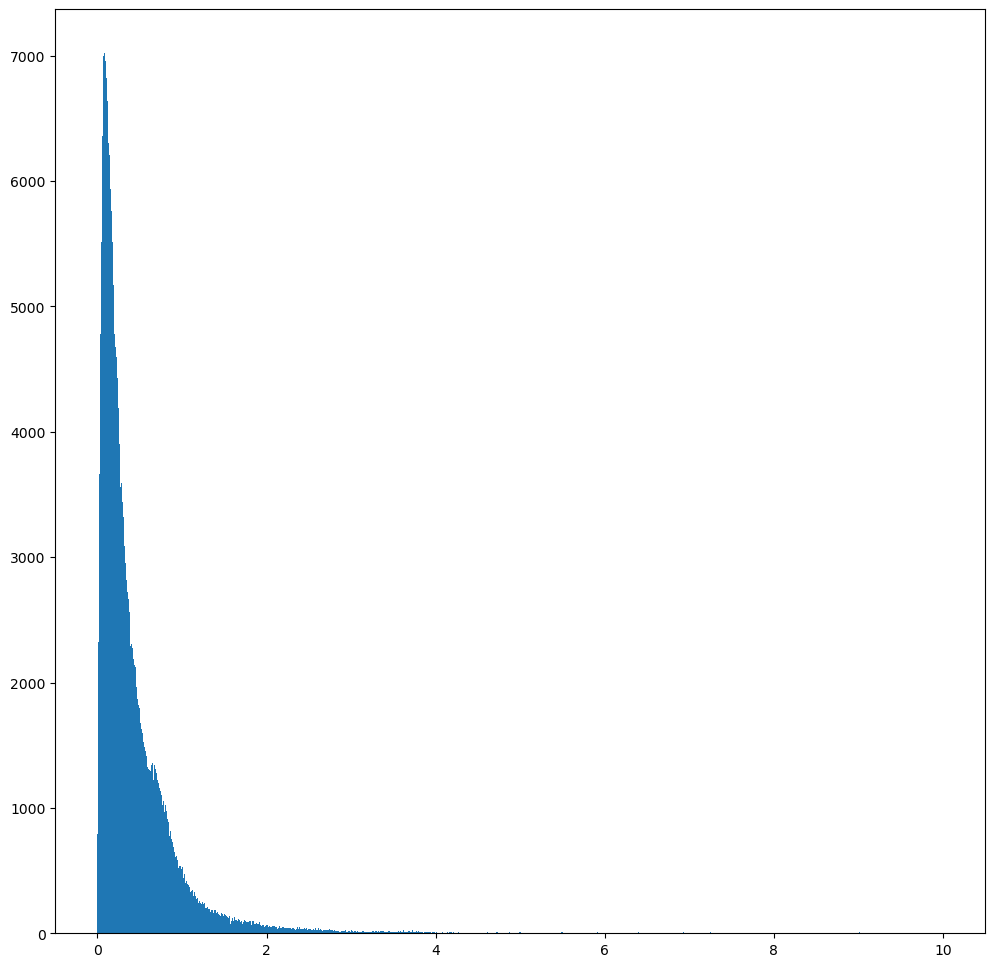

In [7]:
# test some plotting functions

test_obj = stacked_data[2]
sm.plot.plot_hist(test_obj,'Mag_vec', 1000, [0,10])


In [8]:
plt.close('all')

In [9]:
# %matplotlib inline
# # manually check many different vectors to classify as outlier, inlier and confidence on deformation
# import random
# ## make testing data
# # store R_idx, A_idx, flag
# # flag:
# #   0 : outlier
# #   1 : inlier, no def
# #   2 : inlier, def low conf
# #   3 : inlier, def high conf
# test_data = []
# N_test = 10
# # plt.ion()
# for i in range(N_test):
#     idx = random.randint(0,np.size(test_obj.R_off_vec))
#     sm.plot.plot_rand_vec(test_obj,idx,5,0.002,0.3,2)
#     plt.show(block=False)
#     flag = int(input('what is the flag? 0:outlier, 1:inlier, no def., 2: inlier, def.'))
#     if flag not in [0,1,2,3]:
#         print('ERROR: flag needs to be 0, 1, 2, or 3')
#         break
#     test_data.append([test_obj.R_idx_vec[idx], test_obj.A_idx_vec[idx], flag])
#     plt.close()


In [10]:
# print vector field
%matplotlib osx
# sm.plot.plot_vec_attr(test_obj,'Phase',10,50,[0,360],1,shading,DEM_extent)
sm.plot.plot_vec_attr(test_obj,[],10,50,0.01,[0,360],5,shading,DEM_extent,[-7.546, -7.533],[110.435,110.450])


In [11]:
    """calculate local weighted L2 difference of offset vectors using run_wL2.py
This will do multi-core processing but is still slower than the non-multi core one on my mac...
    """

# [X_off,X_off_vec,Y_off_vec,Lat_off_vec,Lon_off_vec,R_idx_vec,A_idx_vec,Row_index_vec,Col_index_vec,A_win,R_win] = test_obj.get_data_4_wL2()
# print('loaded the data')
# test_obj.wL2 = sm.Post_processing.run_wL2(X_off,X_off_vec,Y_off_vec,Lat_off_vec,Lon_off_vec,R_idx_vec,A_idx_vec,Row_index_vec,Col_index_vec,A_win,R_win)



'calculate local weighted L2 difference of offset vectors using run_wL2.py\nThis will do multi-core processing but is still slower than the non-multi core one on my mac...\n'

In [12]:
# test long calculation of local weighted L2
# test_obj.calc_local_L2()


In [13]:
# plot local dissimilarity vector
# sm.plot.plot_vec_attr(test_obj,'wL2',5,50,[0,5],1,shading,DEM_extent,[-7.546, -7.533],[110.435,110.450])


In [14]:
# test HDBSCAN
r_step = 24
a_step = 12
# compute max overlap
overlap = 4*np.ceil((test_obj.R_win/r_step) * (test_obj.A_win/a_step))
min_cluster_size = int(overlap)
min_samples = 1

single_cluster = False
cluster_selection_epsilon = 0.3 # doesnt do much

In [15]:
# run HDBSCAN
test_obj.prep_DBSCAN(1,1,100)
test_obj.run_PCA(4)
test_obj.run_HDBSCAN(min_cluster_size,min_samples,single_cluster,cluster_selection_epsilon)

In [16]:
# plot results from HDBSCAN labels and outlier factor
sm.plot.plot_vec_attr(test_obj,'HDBSCAN_labels',3,50,0.01,[-1,0],5,shading,DEM_extent,[-7.546, -7.533],[110.435,110.450])
sm.plot.plot_vec_attr(test_obj,'HDBSCAN_labels',10,50,0.01,[-1,0],5,shading,DEM_extent,[-7.546, -7.533],[110.435,110.450])
sm.plot.plot_vec_attr(test_obj,'HDBSCAN_outlier_scores',3,50,0.01,[-1,5],5,shading,DEM_extent,[-7.546, -7.533],[110.435,110.450])


In [19]:
# remove DBSCAN outliers

test_obj.rem_outliers_HDBSCAN()
sm.plot.plot_vec_attr(test_obj,'Phase',3,50,0.01,[0,360],1,shading,DEM_extent,[-7.546, -7.533],[110.435,110.450])
sm.plot.plot_vec_attr(test_obj,'HDBSCAN_outlier_scores',3,50,0.01,[-1,5],1,shading,DEM_extent,[-7.546, -7.533],[110.435,110.450])



In [20]:
# remove DBSCAN outliers

# test_obj.rem_outliers_HDBSCAN()
sm.plot.plot_vec_attr(test_obj,'Phase',10,50,0.01,[0,360],1,shading,DEM_extent,[-7.546, -7.533],[110.435,110.450])
sm.plot.plot_vec_attr(test_obj,'HDBSCAN_outlier_scores',10,50,0.01,[-1,5],1,shading,DEM_extent,[-7.546, -7.533],[110.435,110.450])



In [ ]:
# sm.plot.cross_plot(test_obj,'HDBSCAN_outlier_scores','wL2',1,300)

In [21]:
# plot range offset for different window sizes to see nan mask
indeces = [0,2,4,6]
r_offset = np.stack([obj.R_off for obj in datastack.Stack])
plot_data = [r_offset[idx] for idx in indeces]
plot_data = plot_data + [np.isnan(r_offset[idx]) for idx in range(4)]

cmaps = [cm.vik,cm.vik,cm.vik,cm.vik,
         'Greys','Greys','Greys','Greys']
min_clim = [-vmax,-vmax,-vmax,-vmax,
            0,0,0,0]

max_clim = [vmax,vmax,vmax,vmax,
            1,1,1,1]


# initiate figure
textsize = 15
plt.rc('font', size=textsize) 
fig=plt.figure(figsize=(20,12))
gs=GridSpec(2,4) # 3 rows, 5 columns
axes = [fig.add_subplot(gs[i,j]) for i in range(2) for j in range(4)]

for ax,p_data,cmap,clim_min,clim_max in zip(axes,plot_data,cmaps,min_clim,max_clim):
    ax.imshow(p_data,cmap=cmap,vmin=clim_min,vmax=clim_max, interpolation='Nearest')
    ax.set_axis_off()

In [22]:
# perfrom outlier detection and removal for all windows
import time
start = time.time()
for obj in stacked_data:
    print(f'current window size: {obj.R_win}, {obj.A_win}')
    overlap = 4*np.ceil((obj.R_win/r_step) * (obj.A_win/a_step))
    min_cluster_size = int(overlap)
    min_samples = 1
    # run HDBSCAN
    obj.prep_DBSCAN(1,1,100)
    obj.run_PCA(4)
    obj.run_HDBSCAN(min_cluster_size,min_samples,single_cluster,cluster_selection_epsilon)
    obj.rem_outliers_HDBSCAN()
    print(f'time: {time.time()-start}')


current window size: 42, 20
time: 54.32832193374634
current window size: 74, 36
time: 106.65131616592407
current window size: 108, 52
time: 150.00960397720337
current window size: 140, 68
time: 189.44035005569458
current window size: 174, 84
time: 234.09297895431519
current window size: 206, 100
time: 287.6820487976074
current window size: 240, 116
time: 328.7921929359436
current window size: 272, 132
time: 374.0379238128662
current window size: 306, 148
time: 414.770889043808
current window size: 340, 164
time: 458.2549889087677
current window size: 372, 180
time: 499.66523599624634


In [23]:
# plot range offset for different window sizes to see nan mask
indeces = [0,2,4,6]
r_offset = np.stack([obj.R_off for obj in datastack.Stack])
plot_data = [r_offset[idx] for idx in indeces]
plot_data = plot_data + [np.isnan(r_offset[idx]) for idx in range(4)]
nan_masks = np.stack([np.isnan(r_offset[idx]) for idx in range(4)])
nan_frac = np.sum(nan_masks, axis=0) / 4

fig=plt.figure(figsize=(7,7))
plt.imshow(nan_frac)
nan_frac2 = copy.deepcopy(nan_frac)
nan_frac2[nan_frac > 0.5] = np.nan
nan_frac2[nan_frac <= 0.5] = 1
fig=plt.figure(figsize=(7,7))
plt.imshow(nan_frac2)

cmaps = [cm.vik,cm.vik,cm.vik,cm.vik,
         'Greys','Greys','Greys','Greys']
min_clim = [-vmax,-vmax,-vmax,-vmax,
            0,0,0,0]

max_clim = [vmax,vmax,vmax,vmax,
            1,1,1,1]


# initiate figure
textsize = 15
plt.rc('font', size=textsize) 
fig=plt.figure(figsize=(20,12))
gs=GridSpec(2,4) # 3 rows, 5 columns
axes = [fig.add_subplot(gs[i,j]) for i in range(2) for j in range(4)]

for ax,p_data,cmap,clim_min,clim_max in zip(axes,plot_data,cmaps,min_clim,max_clim):
    ax.imshow(p_data,cmap=cmap,vmin=clim_min,vmax=clim_max, interpolation='Nearest')
    ax.set_axis_off()

/var/folders/m9/32v45xkn4zx6js6htb1prb2r0000gn/T/ipykernel_47825/1986891461.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig=plt.figure(figsize=(7,7))


1   HIToolbox                           0x00007ff80b4e9726 _ZN15MenuBarInstance22EnsureAutoShowObserverEv + 102
2   HIToolbox                           0x00007ff80b4e92b8 _ZN15MenuBarInstance14EnableAutoShowEv + 52
3   HIToolbox                           0x00007ff80b458cd7 _ZN15MenuBarInstance21UpdateAggregateUIModeE21MenuBarAnimationStylehhh + 1113
4   HIToolbox                           0x00007ff80b4e9173 _ZN15MenuBarInstance19SetFullScreenUIModeEjj + 175
5   AppKit                              0x00007ff804fb6287 -[NSApplication _setPresentationOptions:instance:flags:] + 1145
6   AppKit                              0x00007ff804e0b055 -[NSApplication _updateFullScreenPresentationOptionsForInstance:] + 582
7   AppKit                              0x00007ff8058597f0 -[_NSFullScreenSpace(PresentationInstance) activateFullScreenPresentationOptions] + 207
8   AppKit                              0x00007ff8056ac5d8 -[_NSEnterFullScreenTransitionController _doSucceededToEnterFullScreen] + 721


In [24]:
def Run_MKA(stack_obj,indeces=[],window_size=1,comp_lim=0.5):
        """
        Run Multi-kernel averaging where user can define seleced indices from the stack, 
        desired window size, and a completion factor as a high pass filter

        Args:
            indices (list, optional): indices of slices from datastack used for MKA. Defaults to [], use all data.
            window_size (int, optional): window dimension for MKA, odd numbers 
                                         prefered because of pixel centering. 
                                         Defaults to 1.
            comp_lim (float, optional): completion limit between [0.0, 1.0]
                                        Only take data for MKA if more than 
                                        comp_lim of the stack is not nan. 
                                        Defaults to 0.5.

        Returns:
            avg_map: Multi-kernel Average map
        """

        if indeces==[]:
            stack_R = [obj.R_off for obj in stack_obj.Stack]
            stack_A = [obj.A_off for obj in stack_obj.Stack]
            stack_ccp = [obj.Ccp_off for obj in stack_obj.Stack]
            stack_ccs = [obj.Ccs_off for obj in stack_obj.Stack]
        else:
            substack = [stack_obj.Stack[i] for i in indeces]
            stack_R = np.stack([obj.R_off for obj in substack],axis=0)
            stack_A = np.stack([obj.A_off for obj in substack],axis=0)
            stack_ccp = np.stack([obj.Ccp_off for obj in substack],axis=0)
            stack_ccs = np.stack([obj.Ccs_off for obj in substack],axis=0)

        avg_maps = []
        for stack in [stack_R,stack_A]:
            stack = stack
            window_shape = (stack.shape[0], window_size, window_size)
            # use view_as_windows to devided data into windows
            print(np.shape(stack))
            win_data = np.lib.stride_tricks.sliding_window_view(stack, window_shape)[0]
            # remove data that is nan for too many different window sizes
            nan_frac = np.sum(np.isnan(win_data), axis=2) / (window_size ** 2)
            nan_frac = nan_frac/np.shape(win_data)[2]
            print(nan_frac[0:10,0:10])
            # fig,ax = plt.subplots(1,1)
            # ax.imshow(nan_frac[:,:,0,0])
            
            nan_frac[nan_frac > comp_lim] = np.nan
            nan_frac[nan_frac <= comp_lim] = 1
            win_data = np.multiply(win_data, nan_frac[..., np.newaxis])
            # define shape of multi-kernel averaged map (same as input data), filled with nan
            Avg_map = np.full(stack.shape[1:], np.nan)
            # per window, go take 95% confidence interval data and take average (mean)
            for win_i in range(win_data.shape[0]):
                if win_i % 50 == 0:
                    print('win_i', win_i)
                for win_j in range(win_data.shape[1]):
                    # extract relevant window
                    win = win_data[win_i, win_j]
                    # calculate 95 % confidence interval
                    percentiles = np.nanpercentile(win, [2.5, 97.5])
                    # mask data outside 95% confidence interval with nan
                    mask = (win < percentiles[0]) | (win > percentiles[1])
                    win[mask] = np.nan
                    # calculate mean of window (offset by floor(window_size/2) because of border)
                    offset = window_size // 2
                    Avg_map[win_i + offset, win_j + offset] = np.nanmean(win)
            avg_maps.append(Avg_map)
        stack_obj.MKA_R_off = avg_maps[0]
        stack_obj.MKA_A_off = avg_maps[1]
        # stack_obj.MKA_Ccp_off = avg_maps[2]
        # stack_obj.MKA_Ccs_off = avg_maps[3]

        return stack_obj.MKA_R_off, stack_obj.MKA_A_off
# run mullti-kernel average
MKA_R_off, MKA_A_off = Run_MKA(datastack,[0,2,4,6],comp_lim=0.50)

(4, 448, 743)
[[[[0.25]]

  [[0.25]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]]


 [[[0.25]]

  [[0.  ]]

  [[0.25]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]]


 [[[0.25]]

  [[0.25]]

  [[0.25]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]

  [[0.25]]

  [[0.25]]

  [[0.25]]]


 [[[0.5 ]]

  [[0.  ]]

  [[0.25]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]

  [[0.25]]

  [[0.  ]]

  [[0.  ]]]


 [[[0.25]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]

  [[0.25]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]]


 [[[0.25]]

  [[0.25]]

  [[0.25]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]

  [[0.25]]

  [[0.  ]]

  [[0.  ]]]


 [[[0.  ]]

  [[0.25]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]

  [[0.25]]

  [[0.25]]]


 [[[0.  ]]

  [[0.25]]

  [[0.25]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]

  [[0.25]]

  [[0.  ]]]


 [[[0.  ]]

/var/folders/m9/32v45xkn4zx6js6htb1prb2r0000gn/T/ipykernel_47825/622319442.py:65: RuntimeWarning: Mean of empty slice
  Avg_map[win_i + offset, win_j + offset] = np.nanmean(win)
/Applications/anaconda3/envs/PhD/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,


win_i 50
win_i 100
win_i 150
win_i 200
win_i 250
win_i 300
win_i 350
win_i 400
(4, 448, 743)
[[[[0.25]]

  [[0.25]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]]


 [[[0.25]]

  [[0.  ]]

  [[0.25]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]]


 [[[0.25]]

  [[0.25]]

  [[0.25]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]

  [[0.25]]

  [[0.25]]

  [[0.25]]]


 [[[0.5 ]]

  [[0.  ]]

  [[0.25]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]

  [[0.25]]

  [[0.  ]]

  [[0.  ]]]


 [[[0.25]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]

  [[0.25]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]]


 [[[0.25]]

  [[0.25]]

  [[0.25]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]

  [[0.25]]

  [[0.  ]]

  [[0.  ]]]


 [[[0.  ]]

  [[0.25]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]

  [[0.  ]]

  [[0.25]]

  [[0.25]]]


 [[[0.  ]]

  [[0.25]]

  [[0.25]]

  [[0.  ]]

  [[0

1   HIToolbox                           0x00007ff80b5f052b _ZN15MenuBarInstance21IsAutoShowHideAllowedEv + 259
2   HIToolbox                           0x00007ff80b4e933e _ZN15MenuBarInstance24UpdateAutoShowVisibilityE5Pointh + 34
3   HIToolbox                           0x00007ff80b45881f _ZN15MenuBarInstance16ForEachMenuBarDoEU13block_pointerFvPS_E + 169
4   HIToolbox                           0x00007ff80b4e993d _ZN15MenuBarInstance20AutoShowHideObserverEjP14OpaqueEventRefPv + 165
5   HIToolbox                           0x00007ff80b44fbd2 _NotifyEventLoopObservers + 153
6   HIToolbox                           0x00007ff80b481fb8 PostEventToQueueInternal + 700
7   HIToolbox                           0x00007ff80b483871 _ZL29CreateAndPostEventWithCGEventP9__CGEventjhP17__CFMachPortBoost + 404
8   HIToolbox                           0x00007ff80b48fee9 _ZL15Convert1CGEventh + 246
9   HIToolbox                           0x00007ff80b48fd91 _ZL16MainLoopObserverjP14OpaqueEventRefPv + 41
10  HIT

In [27]:
from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar scaling
from cmcrameri import cm

idx_for_plot = [0,2,4,6]
map_extent = [0,446,150,550]
zoom_extent = [140,240,310,390]

substack = [datastack.Stack[i] for i in idx_for_plot]
stack_R = np.stack([obj.R_off for obj in substack],axis=0)
stack_A = np.stack([obj.A_off for obj in substack],axis=0)

plot_data = [stack_R[idx][map_extent[0]:map_extent[1],map_extent[2]:map_extent[3]] for idx in range(len(idx_for_plot))]
plot_data.append(MKA_R_off[map_extent[0]:map_extent[1],map_extent[2]:map_extent[3]])
plot_data = plot_data + [stack_R[idx][zoom_extent[0]:zoom_extent[1],zoom_extent[2]:zoom_extent[3]] for idx in range(len(idx_for_plot))]
plot_data.append(MKA_R_off[zoom_extent[0]:zoom_extent[1],zoom_extent[2]:zoom_extent[3]])
plot_data = plot_data + [np.isnan(stack_R[idx][zoom_extent[0]:zoom_extent[1],zoom_extent[2]:zoom_extent[3]]) for idx in range(len(idx_for_plot))]
plot_data.append(np.isnan(MKA_R_off)[zoom_extent[0]:zoom_extent[1],zoom_extent[2]:zoom_extent[3]])

cmaps = [cm.vik,cm.vik,cm.vik,cm.vik,cm.vik,
         cm.vik,cm.vik,cm.vik,cm.vik,cm.vik,
         'Greys','Greys','Greys','Greys','Greys',]
min_clim = [-vmax,-vmax,-vmax,-vmax,-vmax,
            -vmax,-vmax,-vmax,-vmax,-vmax,
            0,0,0,0,0,]

max_clim = [vmax,vmax,vmax,vmax,vmax,
            vmax,vmax,vmax,vmax,vmax,
            1,1,1,1,1,]
all_data_arrays2 = [datastack.Stack[idx] for idx in idx_for_plot]
win_sizes = [str(data.get_window_size()) for data in all_data_arrays2]
win_sizes = win_sizes + ['multi-kernel \naverage']


# initiate figure
textsize = 28
plt.rc('font', size=textsize) 
fig=plt.figure(figsize=(10,10))
gs=GridSpec(3,6) # 3 rows, 5 columns
axes = [fig.add_subplot(gs[i,j]) for i in range(3) for j in range(5)]

for ax,p_data,cmap,clim_min,clim_max in zip(axes,plot_data,cmaps,min_clim,max_clim):
    ax.imshow(p_data,cmap=cmap,vmin=clim_min,vmax=clim_max, interpolation='Nearest')
    ax.set_axis_off()
    
for ax,win_size in zip(axes[0:5],win_sizes):
    ax.add_patch(plt.Rectangle((zoom_extent[2]-map_extent[2], zoom_extent[0]-map_extent[0]), zoom_extent[3]-zoom_extent[2], zoom_extent[1]-zoom_extent[0], ls="-", ec="k", fc="none",
                           ))
    ax.set_title(win_size)

fig.tight_layout()
cbar_pos = axes[4].get_position()
 
cax = plt.axes([cbar_pos.x0+cbar_pos.width + 0.1, cbar_pos.y0-0.08, 0.01, 2 * cbar_pos.height])      
mappable = plt.cm.ScalarMappable(cmap = cm.vik,
                                 norm = plt.Normalize(vmin = -vmax, vmax = vmax))
cbar = fig.colorbar(mappable, cax, orientation = 'vertical')
cbar.set_label('Slant range \noffset [m]', rotation=90, loc= 'center',labelpad=0)

# for ax in axes[0:5]:
#     ax.annotate('slant range',xy=(50,50),xytext=(0,-50),textcoords='offset pixels', xycoords='data',
#                     arrowprops=dict(facecolor='black',arrowstyle='<-'),horizontalalignment='center',verticalalignment='top',rotation=90)
#     ax.annotate('azimuth',xy=(50,50),xytext=(50,0),textcoords='offset pixels' ,xycoords='data',
#                     arrowprops=dict(facecolor='black',arrowstyle='<-'),horizontalalignment='left',verticalalignment='center')
textsize = 24
plt.rc('font', size=textsize) 
for ax in axes[-10:-5]:
    ax.annotate('slant range',xy=(5,5),xytext=(0,-50),textcoords='offset pixels', xycoords='data',
                    arrowprops=dict(facecolor='black',arrowstyle='<-',width=10),horizontalalignment='center',verticalalignment='top',rotation=90)
    ax.annotate('azimuth',xy=(5,5),xytext=(50,0),textcoords='offset pixels' ,xycoords='data',
                    arrowprops=dict(facecolor='black',arrowstyle='<-',width=10),horizontalalignment='left',verticalalignment='center')

# fig.tight_layout()
fig.subplots_adjust(hspace=0.05)


AttributeError: FancyArrowPatch.set() got an unexpected keyword argument 'width'

1   HIToolbox                           0x00007ff80b4e9726 _ZN15MenuBarInstance22EnsureAutoShowObserverEv + 102
2   HIToolbox                           0x00007ff80b458ce3 _ZN15MenuBarInstance21UpdateAggregateUIModeE21MenuBarAnimationStylehhh + 1125
3   HIToolbox                           0x00007ff80b4e9173 _ZN15MenuBarInstance19SetFullScreenUIModeEjj + 175
4   AppKit                              0x00007ff804fb6287 -[NSApplication _setPresentationOptions:instance:flags:] + 1145
5   AppKit                              0x00007ff804e0b055 -[NSApplication _updateFullScreenPresentationOptionsForInstance:] + 582
6   CoreFoundation                      0x00007ff801b203d4 __CFNOTIFICATIONCENTER_IS_CALLING_OUT_TO_AN_OBSERVER__ + 137
7   CoreFoundation                      0x00007ff801bba41a ___CFXRegistrationPost_block_invoke + 88
8   CoreFoundation                      0x00007ff801bba369 _CFXRegistrationPost + 536
9   CoreFoundation                      0x00007ff801af38f9 _CFXNotificationPost +

In [ ]:
plt.close('all')